<a href="https://colab.research.google.com/github/juantijero/ML_HW/blob/main/HW6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

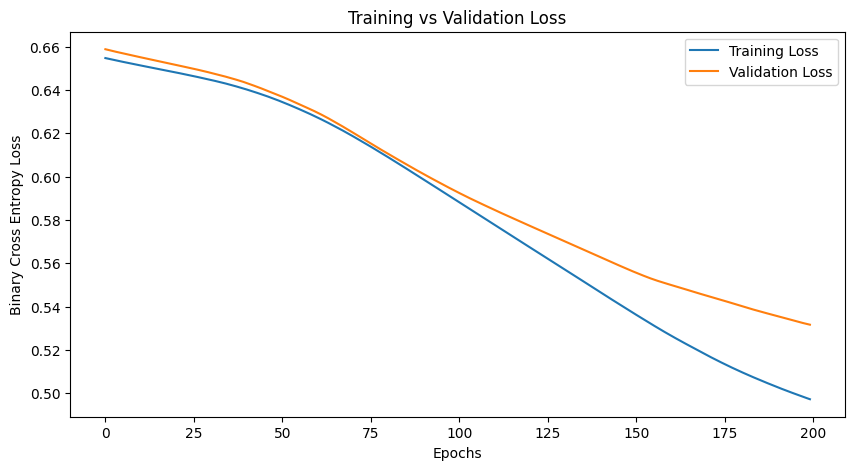


Model Performance Comparison:
                     Accuracy  Precision    Recall  F1 Score
Model                                                       
Neural Network       0.772727   0.685185  0.672727  0.678899
Logistic Regression  0.753247   0.649123  0.672727  0.660714
SVM                  0.733766   0.645833  0.563636  0.601942


In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# ==========================================
# 1. Data Loading and Preprocessing
# ==========================================

# Load the dataset locally from Colab
filename = 'diabetes.csv'

# NOTE: If your csv has no headers, remove 'header=0' and pass 'names=...'
# We assume the standard format with headers:
# Pregnancies, Glucose, BloodPressure, SkinThickness, Insulin, BMI, DiabetesPedigreeFunction, Age, Outcome
df = pd.read_csv(filename)

# Separate features (X) and target (y)
# 'Outcome' is usually the target column name in this dataset
X = df.drop('Outcome', axis=1).values
y = df['Outcome'].values

# Split data: 80% Training, 20% Validation
X_train_raw, X_val_raw, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature Scaling (Standardization) - Essential for Neural Network convergence
# Lecture 3: Scaling ensures gradient descent moves smoothly towards minima [cite: 2400]
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_raw)
X_val = scaler.transform(X_val_raw)

# Convert to PyTorch Tensors (Float32 is standard for weights)
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1) # Reshape to (N, 1)
X_val_t = torch.tensor(X_val, dtype=torch.float32)
y_val_t = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)

# ==========================================
# 2. Neural Network Definition
# ==========================================

class DiabetesModel(nn.Module):
    def __init__(self, input_dim):
        super(DiabetesModel, self).__init__()
        # Lecture 10: Stacking linear layers + non-linear activations
        self.layer1 = nn.Linear(input_dim, 7)
        self.act1 = nn.ReLU() # ReLU is standard for hidden layers
        self.layer2 = nn.Linear(7, 7)
        self.act2 = nn.ReLU()
        self.layer3 = nn.Linear(7, 7)
        self.act3 = nn.ReLU()
        self.output = nn.Linear(7, 1)
        self.sigmoid = nn.Sigmoid() # Sigmoid maps output to [0,1] probability

    def forward(self, x):
        x = self.act1(self.layer1(x))
        x = self.act2(self.layer2(x))
        x = self.act3(self.layer3(x))
        x = self.sigmoid(self.output(x))
        return x

model = DiabetesModel(X_train.shape[1])

# ==========================================
# 3. Training Loop
# ==========================================

# Loss function: Binary Cross Entropy (Lecture 4 Cost Function)
loss_fn = nn.BCELoss()

# Optimizer: Adam is generally faster/more stable than vanilla SGD (Lecture 8)
optimizer = optim.Adam(model.parameters(), lr=0.001)

n_epochs = 200
train_losses = []
val_losses = []

for epoch in range(n_epochs):
    # --- Training Phase ---
    model.train()
    y_pred = model(X_train_t)
    loss = loss_fn(y_pred, y_train_t)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())

    # --- Validation Phase ---
    # Lecture 9: We evaluate loss on validation set to check generalization [cite: 2469]
    model.eval()
    with torch.no_grad():
        y_val_pred = model(X_val_t)
        v_loss = loss_fn(y_val_pred, y_val_t)
        val_losses.append(v_loss.item())

# ==========================================
# 4. Evaluation & Reporting
# ==========================================

# Plotting Loss (Lecture 9: Check for divergence)
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Binary Cross Entropy Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()

# Helper function for metrics
def get_metrics(y_true, y_pred, model_name):
    return {
        "Model": model_name,
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "F1 Score": f1_score(y_true, y_pred)
    }

# 1. Neural Network Metrics
model.eval()
with torch.no_grad():
    # Convert probabilities to 0 or 1 labels
    nn_preds = (model(X_val_t) > 0.5).float().numpy()

nn_results = get_metrics(y_val, nn_preds, "Neural Network")

# 2. Logistic Regression Metrics (Lecture 4 Baseline)
lr = LogisticRegression()
lr.fit(X_train, y_train)
lr_preds = lr.predict(X_val)
lr_results = get_metrics(y_val, lr_preds, "Logistic Regression")

# 3. SVM Metrics (Lecture 6 Baseline)
svm = SVC(kernel='rbf') # RBF kernel allows non-linear boundaries [cite: 299]
svm.fit(X_train, y_train)
svm_preds = svm.predict(X_val)
svm_results = get_metrics(y_val, svm_preds, "SVM")

# Display Comparison Table
results_df = pd.DataFrame([nn_results, lr_results, svm_results])
print("\nModel Performance Comparison:")
print(results_df.set_index("Model"))